# Bayesian analysis of the empirical saturation point

This notebook provides an implementation of the saturation analysis using conjugate priors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import corner
import matplotlib as mpb
from scipy.stats import invwishart, multivariate_normal, multivariate_t
from matplotlib.patches import Rectangle
import pymc3 as pm
from modules.plot_helpers import *
import seaborn as sns
import re
import glob

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
pdf_path = "./pdf"
if not os.path.exists(pdf_path):
    os.mkdir(pdf_path)

## Empirical constraints: status quo

### Empirical box used in many-body theory

In [4]:
def plot_saturation_box(ax=None, filenames=None, plot_scatter=True, print_result=True,
                        facecolor='lightgray', edgecolor='gray', alpha=0.4, zorder=9, **kwargs):
    # read data (support for data from multiple files)
    filenames = filenames if filenames else ("satpoints_dutra_skyrme.csv", "satpoints_kortelainen.csv", "Brown/satpoints_brown.csv")
    data = pd.DataFrame()
    for file in filenames:
        data_read = pd.read_csv(f"data/{file}", comment="#", dtype={"Label":str, "rho0":np.float64, "E/A": np.float64})
        data_read["origin"] = re.search("satpoints_(\w*).csv", file).group(1)
        data = pd.concat([data, data_read], copy=False, ignore_index=True)

    # compute constraint
    result = dict()
    for dim in ("rho0", "E/A"):
        df = data[dim]
        uncert = (df.max() - df.min())/2.
        central = df.min() + uncert
        result[dim] = (central, uncert)

    # print results if requested
    if print_result:
        print("Empirical saturation point from Drischler et al. (2016):")
        print(f"n0 = {result['rho0'][0]:.3f} +/- {result['rho0'][1]:.3f} fm^(-3)")
        print(f"E0/A = {result['E/A'][0]:.1f} +/- {result['E/A'][1]:.1f} MeV")

    # plot constraint
    if ax is None:
        ax = plt.gca()
    left, right = result['rho0'][0] - result['rho0'][1], result['rho0'][0] + result['rho0'][1]
    down = result['E/A'][0] - result['E/A'][1]
    rect = Rectangle(
        (left, down), width=2*result['rho0'][1], height=2*result['E/A'][1], label=r"Drischler \textit{et al.}",
        facecolor=facecolor, edgecolor=edgecolor, alpha=alpha, zorder=zorder, **kwargs
    )
    ax.add_patch(rect)

    # plot scatter
    if plot_scatter:
        marker_size = 8
        for index, (mask_lbl, legend_lbl) in enumerate((("kortelainen", r"Kortelainen \textit{et al.}"), ("brown_schwenk", r"Dutra \textit{et al.}"), ("brown", "Brown"))):
            mask = data['origin'] == mask_lbl
            ax.scatter(data[mask]["rho0"], data[mask]["E/A"], color=colors[index], s=marker_size, label=legend_lbl)
    return data, result

The results should match the results from the Drischler et al. paper (2016):
$$
n^\mathrm{emp}_0 = (0.164 \pm 0.007) \, \mathrm{fm}^{−3} \quad E^\mathrm{emp}/A \approx −(15.9 \pm 0.4) \mathrm{MeV}
$$
Skyrme energy-density functionals based on properties of nuclei and nuclear matter can be used to empirically constrain the saturation point [50–52]. Table 7 of Ref. [50] summarizes 16 selected functionals, which reproduce well selected properties of nuclear matter. Six more are excluded because of unreasonable behavior for large densities [50] or being unstable for finite nuclei. The remaining ten are listed in Table 1 of Ref. [52]. Our empirical saturation range is determined based on these functionals plus those of Ref. [53] (SLy4, UNEDF0, UNEDF1, and UNEDF2). As a result we obtain the ranges nemp0 = (0.164 ± 0.007) fm−3 and boxes in Figs. 4 (for x = 0.5) and 5. Eemp/A ?−(15.9 ± 0.4) MeV, whic

Empirical saturation point from Drischler et al. (2016):
n0 = 0.164 +/- 0.007 fm^(-3)
E0/A = -15.9 +/- 0.4 MeV


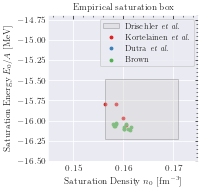

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
data = plot_saturation_box(ax=ax)
ax.set_xlim(0.145, 0.175)
ax.set_ylim(-16.5, -14.7)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=1, prop={'size': 8})
ax.set_title("Empirical saturation box")
fig.savefig("pdf/empirical_sat_box.pdf")

### Relativistic Mean Field (Dutra et al.)

In [6]:
def plot_rmf_dutra(ax=None, filenames=None):
    # read data (support for data from multiple files)
    filenames = filenames if filenames else ("satpoints_rmf_dutra_2014.csv",)
    data = pd.DataFrame()
    for file in filenames:
        data_read = pd.read_csv(f"data/{file}", comment="#", dtype={"Label":str, "rho0":np.float64, "E/A": np.float64})
        data_read["origin"] = re.search("satpoints_(\w*).csv", file).group(1)
        data = pd.concat([data, data_read], copy=False, ignore_index=True)
    ax.scatter(data["rho0"], data["E/A"], color=colors[-5], s=8, label=r"Dutra \textit{et al.}")
    return data
data_dutra = plot_rmf_dutra(ax)

### Relativisitc energy functionals

In [7]:
def plot_saturation_piekarewicz(ax=None, n_std=2, alpha=0.4, **kwargs):
    # read files
    files = sorted(glob.glob("data/Piekarewicz/*/CovEllipse.com"))
    data = []; labels = []
    for file in files:
        labels.append(re.search("(\w+)/Cov", file).group(1))
        data.append(open(file, 'r').readlines()[3].strip().split(","))
    data = pd.DataFrame(data, columns=("rho0", "E/A", "sigma rho0", "sigma E/A", "rho"), dtype=np.float64)
    data["label"] = labels

    # determine mean vector and covariance matrix from data set
    def get_mean_cov_rmf(row):
        mean = np.array([row["rho0"], row["E/A"]])
        cov_offdiag = row["sigma rho0"]*row["sigma E/A"]*row["rho"]
        cov = np.array([[row["sigma rho0"]**2, cov_offdiag], [cov_offdiag, row["sigma E/A"]**2]])
        return mean, cov

    # plot the constraints
    if ax is None:
            ax = plt.gca()
    for index, row in data.iterrows():
        mean, cov = get_mean_cov_rmf(row)
        confidence_ellipse_mean_cov(mean=mean, cov=cov, n_std=n_std, ax=ax,
                                    facecolor=colors[index], alpha=alpha, label=row["label"] + f" ({n_std:d}$\sigma$)", **kwargs)
    return data

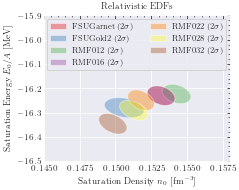

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(1.25*6.8*cm, 6.8*cm))
plot_saturation_piekarewicz(ax=ax)
ax.set_xlim(0.145, 0.158)
ax.set_ylim(-16.5, -15.9)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=2, prop={'size': 8})
ax.set_title("Relativistic EDFs")
fig.savefig("pdf/satpoints_rmf_piekarewicz.pdf")

### Nonrelativistic EDFs

In [9]:
def plot_saturation_schunck(ax=None, levels=86, fill=False, num_sample=None):
    # Number of contour levels or values to draw contours at.
    # A vector argument must have increasing values in [0, 1].
    # Levels correspond to iso-proportions of the density:
    # e.g., 20% of the probability mass will lie below the contour drawn for 0.2. Only relevant with bivariate data.
    # Note that 39% corresponds to 1sigma, and 86% to 2sigma regions
    levels = 1. - np.atleast_1d(levels)/100.
    if fill:
        levels = np.append(levels, 1.)
    data = pd.DataFrame()
    num_sample = range(1,num_sample+1) if num_sample else range(1,3+1)
    for isample in num_sample:
        data_read = pd.read_csv(f"data/Schunck/samples{isample}.csv", comment="#", names=("rho0", "E/A"), skiprows=0)
        sns.kdeplot(ax=ax, x=data_read["rho0"], y=data_read["E/A"], fill=fill, levels=levels,
                    label=f"sample set {isample}" + f" ({(1-levels[0])*100:.0f}\%)",
                    legend=False, color=colors[-isample])  # TODO: sns.kdeplot() seems to have issues with displaying the handles in legends
        data_read["sample no."] = isample
        data = pd.concat([data, data_read])
    return data

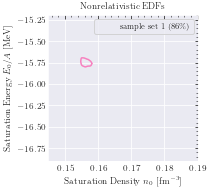

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
data = plot_saturation_schunck(ax=ax, num_sample=1, fill=False)
ax.set_xlim(0.145, 0.19)
ax.set_ylim(-16.9, -15.2)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=1, prop={'size': 8})
ax.set_title("Nonrelativistic EDFs")
fig.savefig("pdf/satpoints_schunck.pdf")

### Summary Figure

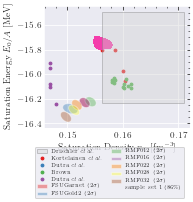

In [11]:
def plot_dft_constraints():
    fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 1.*6.8*cm), constrained_layout=True)
    plot_saturation_box(ax=ax, print_result=False)
    plot_rmf_dutra(ax=ax)
    plot_saturation_piekarewicz(ax=ax)
    plot_saturation_schunck(ax=ax, num_sample=1, fill=True)
    # ax.set_xlim(0.145, 0.19)
    # ax.set_ylim(-16.9, -15.2)
    ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
    ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
    ax.legend(bbox_to_anchor=(0.45, -0.6), loc='lower center', ncol=2, prop={'size': 5})
    #ax.set_title("Summary of DFT constraints")
    fig.savefig("pdf/satpoints_summary.pdf")
    return fig, ax
fig, ax = plot_dft_constraints()

## Bayesian inference of the Coester Band

We perform a Bayesian regression with the (generic) linear model:
\begin{equation}
y_i(x_i) =\beta_0 + \beta_1 x_i +\epsilon_i ,
\end{equation}
where $\lbrace (x_i, y_i) \rbrace_i$ corresponds to the data set, \ie, the predicted saturation densities and energies per particle, respectively, and $\beta_0$ and $\beta_1$ are the to-be-determined parameters.
We model the uncertainties in the predicted energies per particle using a normally distributed noise term, $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ with the to-be-estimated standard deviation $\sigma$.
Note that these uncertainties are modeled as random draws from a single distribution for each data point.

In [12]:
data_eft_full = pd.read_csv("data/satpoint_predicted.csv")
data_eft_curated = data_eft_full[((data_eft_full["method"]=="MBPT") & (data_eft_full["mbpt_order"]==4)) | (data_eft_full["method"]=="MBPT*")]

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta_1, beta_0]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 45 seconds.


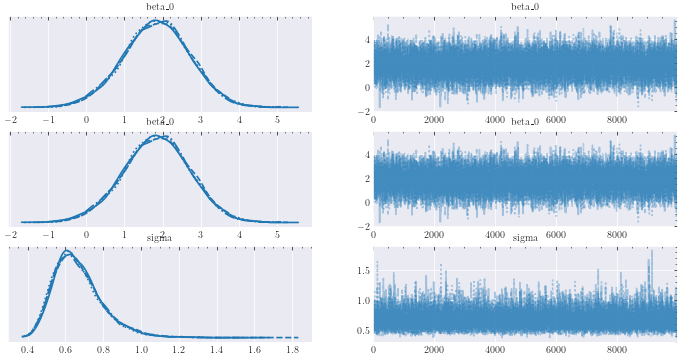

In [13]:
with pm.Model() as model:
    x_data = pm.Data("x_data", data_eft_curated["n0"])
    beta_0 = pm.Normal("beta_0", mu=1.5, sd=1)
    beta_1 = pm.Normal("beta_1", mu=-100, sd=50)
    sigma = pm.InverseGamma("sigma", alpha=6, beta=5)
    y = pm.Normal('y', mu=beta_0 + beta_1 * x_data, sd=sigma, observed=data_eft_curated["En0"])

    step = pm.NUTS(target_accept=.95)
    trace = pm.sample(draws=10000, tune=2000, step=step, return_inferencedata=False) # , nuts_kwargs=dict(target_accept=0.90))
    pm.plot_trace(trace, ["beta_0", "beta_0", "sigma"])
    plt.show()
    #pm.display(pm.summary(trace, round_to=2))

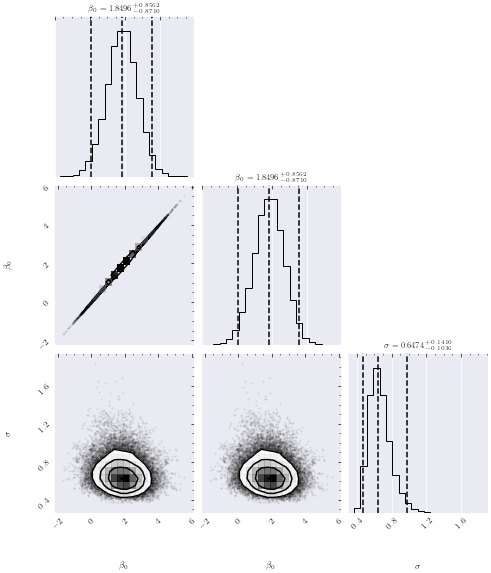

In [14]:
with model:
    names = ["beta_0", "beta_0", "sigma"]
    labels = [r"$\beta_0$", r"$\beta_0$", r"$\sigma$"]
    figure = mpb.figure.Figure(figsize=(1.05*17.88*cm, 2.5*8.6*cm))
    corner.corner(trace, var_names=names, labels=labels, # truths={**physical_point, "error": sigma},
                  quantiles=(0.025, 0.5, 0.975),
                  title_quantiles=(0.025, 0.5, 0.975),
                  show_titles=True, title_fmt=".4f", title_kwargs={"fontsize": 8}, fig=figure)
    figure.savefig(f"{pdf_path}/corner_coester_params.pdf")
figure

In [15]:
x_validate = np.linspace(0.14, 0.20, 10)
with model:
    pm.set_data({"x_data": x_validate}, model=model)
    posterior_predict = pm.sample_posterior_predictive(trace)

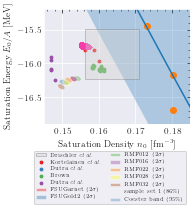

In [16]:
fig, ax = plot_dft_constraints()
level=95 # in percent
lower = np.quantile(posterior_predict["y"], q=0.5-level/200, axis=0)
upper = np.quantile(posterior_predict["y"], q=0.5+level/200, axis=0)
ax.fill_between(x_validate, lower, upper, alpha=0.3, label=f"Coester band ({level:.0f}\%)")
ax.scatter(data_eft_curated["n0"], data_eft_curated["En0"])
ax.plot(x_validate, np.median(posterior_predict["y"], axis=0)) #, label="Coester band")
ax.legend(bbox_to_anchor=(0.45, -0.72), loc='lower center', ncol=2, prop={'size': 5})
ax.set_xlim(0.145, 0.185)
ax.set_ylim(-16.9, -15.2)
fig.savefig(f"{pdf_path}/satpoints_predicted.pdf")

## Bayesian inference of the empirical saturation point

In [17]:
class StatisticalModel:
    def __init__(self, data, quantities, prior_params):
        self.data = data
        self.quantities = quantities
        self.prior_params = prior_params

    @property
    def n(self):
        """
        Number of data points used for inference
        """
        return len(self.data)

    @property
    def d(self):
        """
        Dimensionality of the statistical model;
        for the saturation point, d = 2 [i.e, n0, E0/A]
        """
        return len(self.quantities)

    @property
    def sample_mean(self):
        """
        returns the sample mean vector \bar{y} of length d
        """
        return self.data[self.quantities].mean()

    @property
    def sum_squared_dev(self):
        """
        returns the sum of the squared deviations matrix, i.e., the symmetric S matrix (d x d)
        """
        diff = self.data[self.quantities] - self.sample_mean
        return np.sum([np.outer(row.to_numpy(), row.to_numpy()) for irow, row in diff.iterrows()], axis=0)

    @staticmethod
    def _validate_matrix(mat, raise_error=False, rtol=1e-05, atol=1e-08):
        """
        Checks that the matrix `mat` is symmetric and positive semi-definite
        :param mat: matrix
        :param raise_error: raise error if not symmetric and positive semi-definite
        :param rtol: relative tolerance used for comparison
        :param atol: absolute tolerance used for comparision
        :return: returns boolean result of the validation
        """
        stat_sym = np.allclose(mat, mat.T, rtol=rtol, atol=atol)
        stat_pos_semi_def = np.all(np.linalg.eigvals(mat) >= 0)
        stat = stat_sym and stat_pos_semi_def
        if not stat and raise_error:
            raise ValueError("Non-symmetric and/or non-positive definite matrix encountered.")
        else:
            return stat

    @property
    def posterior_params(self):
        """
        Parameters of the posterior distribution; both the posterior and prior are normal inverse-Wishart distributions
        For the analytic expressions, see
            * https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution#Posterior_distribution_of_the_parameters
            * Equations (250) through (254) in Murphy's notes: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
            * page 73 (pdf page 83) in Gelman et al.'s book: http://www.stat.columbia.edu/~gelman/book/BDA3.pdf

        :return: parameters of the distribution
        """
        ret = dict()
        ret["kappa"] = self.prior_params["kappa"] + self.n
        ret["nu"] = self.prior_params["nu"] + self.n
        ret["mu"] = np.array([self.prior_params["kappa"], self.n]) @ np.array([self.prior_params["mu"], self.sample_mean]) / ret["kappa"]
        diff = self.sample_mean - self.prior_params["mu"]
        ret["Psi"] = self.prior_params["Psi"] + self.sum_squared_dev + (self.prior_params["kappa"] * self.n / ret["kappa"]) * np.outer(diff, diff)
        StatisticalModel._validate_matrix(ret["Psi"], raise_error=True)
        return ret

    def sample_mu_Sigma(self, num_samples=1, based_on="posterior", random_state=None):
        """
        Samples the posterior pr(\mu, \Sigma), which is a normal-inverse-Wishart distribution, in a two-step process.
        For more information on the sampling, see:
            * https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution#Generating_normal-inverse-Wishart_random_variates
            * page 73 (pdf page 83) in Gelman et al.'s book: http://www.stat.columbia.edu/~gelman/book/BDA3.pdf

        :param num_samples: number of samples
        :based_on: either "posterior" or "prior"
        :param random_state: state of the random number generator
        :return: returns `num_samples` samples of either the posterior or prior
        """
        if based_on not in ("posterior", "prior"):
            raise ValueError(f"Got unknown prior/posterior request '{based_on}'.")
        params = self.posterior_params if based_on=="posterior" else self.prior_params
        Sigmas = invwishart.rvs(df=params["nu"], scale=params["Psi"], size=num_samples, random_state=None)
        # TODO: note that `params["Psi"]` vs `np.linalg.inv(params["Psi"])` in the previous line (see also TODO below)
        if num_samples == 1:
            Sigmas = np.expand_dims(Sigmas, 0)
        mus = np.array([multivariate_normal.rvs(mean=params["mu"], cov=Sigma/params["kappa"],
                                                size=1, random_state=random_state) for Sigma in Sigmas])
        return mus, Sigmas

    def sample(self, num_samples=1, kind="predictive_y", based_on="posterior", random_state=None, validate=True):
        """
        Samples prior, posterior, or marginal distribution functions, if available
        For the analytic expressions, see
            * https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution#Posterior_distribution_of_the_parameters
            * Chapter 9 in Murphy's notes: https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
            * see page 73 (pdf page 83) in Gelman et al.'s book: http://www.stat.columbia.edu/~gelman/book/BDA3.pdf

        :param num_samples: number of requested samples
        :param kind: "predictive_y", "marginal_mu", "marginal_Sigma", or "none"
        :param based_on: either "posterior" or "prior"
        :param random_state: state of random number generator
        :param validate: validate that the covariance matrix is symmetric and positive semi-definite
        :return: samples in an array with columns associated with (density, energy/particle)
        """
        # validate inputs for 'kind' and 'based_on'
        if kind not in ("predictive_y", "marginal_mu", "marginal_Sigma", "none"):
            raise ValueError(f"Got unknown 'kind' request '{kind}'.")
        if based_on not in ("posterior", "prior"):
            raise ValueError(f"Got unknown 'based_on' request '{based_on}'.")
        #if kind =="predictive_y" and based_on == "prior":  # TODO: Is our implementation of the prior predictive correct?
        #    raise ValueError("Predictive prior not implemented.")

        # select parameter sets based on posterior or prior
        params = self.posterior_params if based_on == "posterior" else self.prior_params

        # sample requested distribution and return results
        if kind in ("none", "marginal_Sigma"):
            mus, Sigmas = self.sample_mu_Sigma(num_samples=num_samples, based_on=based_on, random_state=random_state)
            if kind == "none":  # plain prior or posterior requested; i.e., no marginalization involved
                return mus, Sigmas
            else:  # marginal_Sigma
                return Sigmas  # Eq. (255) in Murphy's notes #TODO: understand here why Murphy and Gelman have the matrix inverse but not Wikipedia
        else:  # "predictive_y" or "marginal_mu"
            extra_factor = (params["kappa"]+1) if kind=="predictive_y" else 1.
            shape_matrix = params["Psi"]*extra_factor/(params["kappa"]*(params["nu"]-self.d+1))
            if validate:
                StatisticalModel._validate_matrix(shape_matrix, raise_error=True)
            return multivariate_t.rvs(df=params["nu"] - self.d + 1,
                                      loc=params["mu"],
                                      shape=shape_matrix,
                                      size=num_samples, random_state=random_state)  # Eqs. (256) and (258) in Murphy's notes

    def sample_predictive_bf(self, num_samples=1, based_on="posterior", random_state=None):
        """
        Samples the posterior predictive brute-force in the two-step process described in
        https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution#Posterior_distribution_of_the_parameters

        :param num_samples: number of requested samples
        :param based_on: either using the prior or posterior
        :param random_state: state of random number generator
        :return: `num_samples` samples in an array with columns associated with (density, energy/particle)
        """
        mus, Sigmas = self.sample_mu_Sigma(num_samples=num_samples, based_on=based_on, random_state=random_state)
        return np.array([multivariate_normal.rvs(mean=mu, cov=Sigma, size=1) for mu, Sigma in zip(mus, Sigmas)])

    def sanity_check(self, num_samples=10000, based_on="posterior", do_print=False, quantile_values=None, atol=5e-2, rtol=0.):
        """
        Checks that the quantiles obtained from sampling the (analytic) posterior predictive matches the
        brute-force calculation described in https://en.wikipedia.org/wiki/Normal-inverse-Wishart_distribution#Posterior_distribution_of_the_parameters

        :param num_samples: number of samples
        :param based_on: either using the prior or posterior
        :param do_print: print intermediate results
        :param quantile_values: requested quantiles for comparison
        :param atol: absolute tolerance of comparison
        :param rtol: relative tolerance of comparison
        :return: boolean result of the comparison
        """
        quantile_values = quantile_values if quantile_values else (0.05, 0.5, 0.95)
        samples = self.sample(num_samples=num_samples, kind="predictive_y", based_on=based_on)
        quantiles_cp = np.quantile(samples, q=quantile_values, axis=0)
        samples_bf = self.sample_predictive_bf(num_samples=num_samples, based_on=based_on)
        quantiles_bf = np.quantile(samples_bf, q=quantile_values, axis=0)
        stat = np.allclose(quantiles_cp, quantiles_bf, atol=atol, rtol=rtol)
        if do_print:
            print(f"sanity check based on predictive '{based_on}'")
            print("quantiles conj. prior:", quantiles_cp)
            print("quantiles brute-force:", quantiles_bf)
            print("passed:", stat)
        return stat

In [18]:
prior_params = {"mu": np.array([0.16, -15.9]),
                "Psi": np.array([[0.01**2, 0], [0, 0.32**2]]),
                "kappa": 1, "nu": 4}  # TODO: this prior is way too uninformed for the "true" nuclear saturation point. Make it realistic.
spoint = StatisticalModel(data=data_dutra, quantities=["rho0", "E/A"], prior_params=prior_params)
#spoint.posterior_params
#spoint.sample(num_samples=2, kind="predictive_y")
#mu, Sig = spoint.sample_mu_Sigma(num_samples=5, based_on="prior")
#spoint.sample_predictive_bf(num_samples=5)
spoint.sanity_check(num_samples=1000000, based_on="prior", do_print=True)  # might take a few minutes

sanity check based on predictive 'prior'
quantiles conj. prior: [[  0.14086702 -16.51472214]
 [  0.16001443 -15.90004093]
 [  0.17921953 -15.28535538]]
quantiles brute-force: [[  0.14080495 -16.51607259]
 [  0.15999454 -15.9001955 ]
 [  0.17919259 -15.2831272 ]]
passed: True


True

In [19]:
np.random.seed(42)
tmp = multivariate_normal.rvs(mean=prior_params["mu"], cov=prior_params["Psi"], size=1000)
data = pd.DataFrame(data={"n0": tmp[:, 0], "E0": tmp[:, 1]})

In [20]:
spoint = StatisticalModel(data=data, quantities=["n0", "E0"], prior_params=prior_params)
spoint.posterior_params

{'kappa': 1001,
 'nu': 1004,
 'mu': array([  0.16056925, -15.88939104]),
 'Psi': array([[1.03011545e-01, 8.06869820e-03],
        [8.06869820e-03, 9.46951596e+01]])}

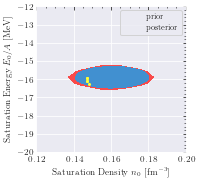

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6.8*cm, 6.8*cm))
levels = [0.16, 1.]
for ibon, bon in enumerate(("prior", "posterior")):
    dd = spoint.sample(num_samples=500000, kind="predictive_y", based_on=bon)  # 500000
    sns.kdeplot(ax=ax, x=dd[:,0], y=dd[:,1], fill=True, levels=levels,
                label=f"{bon}",
                legend=False, color=colors[ibon])  # TODO: sns.kdeplot() seems to have issues with displaying the handles in legends
    # TODO: how to plot the credibility regions without KDE and ideally even without sampling??
ax.scatter(data_dutra["rho0"], data_dutra["E/A"], s=4, c=colors[5])
ax.set_xlim(0.12, 0.20)
ax.set_ylim(-20., -12.)
ax.set_xlabel('Saturation Density $n_0$ [fm$^{-3}$]')
ax.set_ylabel('Saturation Energy $E_0/A$ [MeV]')
ax.legend(ncol=1, prop={'size': 8})
#ax.set_title("Empirical saturation box")
fig.savefig(f"{pdf_path}/output.pdf")

Let's analysis the predictives. Here, the posterior predictive, which seems to behave ok.

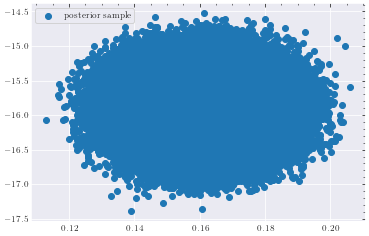

In [22]:
xx=spoint.sample(num_samples=500000, kind="predictive_y", based_on="posterior")
plt.scatter(xx[:,0], xx[:,1], label="posterior sample")
plt.legend()
plt.savefig(f"{pdf_path}/predictive_posterior_samples.pdf")

However, the prior predictive does not behave ok. Look at the ranges of the axes. Huge. Evaluate multiple times. Does that mean our prior is too uninformed? Anyway, the ranges allowed for the density and energy per particle by the prior examples why the prior region above looks weird---because the KDE has a hard time.

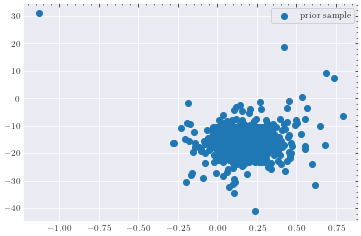

In [23]:
xx=spoint.sample(num_samples=500000, kind="predictive_y", based_on="prior")
plt.scatter(xx[:,0], xx[:,1], label="prior sample")
plt.legend()
plt.savefig(f"{pdf_path}/predictive_prior_samples.pdf")

### Data I/O

In [24]:
data_dutra.sample(1, replace=True)

,Label,rho0,E/A,origin
2,BSR11,0.147,-16.08,rmf_dutra_2014


In [25]:
data_dutra

,Label,rho0,E/A,origin
0,BKA22,0.147,-15.91,rmf_dutra_2014
1,BKA24,0.147,-15.95,rmf_dutra_2014
2,BSR11,0.147,-16.08,rmf_dutra_2014
3,BSR12,0.147,-16.10,rmf_dutra_2014
4,Z271v5,0.148,-16.24,rmf_dutra_2014
